# Intertidal Exposure calculation

Calculate the percentage time that intertidal regions are exposed (emersed) from tide coverage (seawater) by comparing the intertidal elevation against long-term local tide modelling

1. Select an area of interest from the interactive map by drawing a polygon around your area *and* using a marker to designate the location of the tide post for tidal modelling.
2. Extract the all-time NIDEM C2 values for the area of interest
3. Determine the input parameters for the tidal modelling including: 
    - modelling time period (ideally a full nodal cycle, 18.6 years, to incorporate the full range of tidal harmonics)
    - any filters on the tide modelling (e.g. solar exposure, seasonality, spring/neap tidal cycles etc)
4. Run the tidal model and create a relative cumulative frequency (CF) distribution of the results
5. Using xarray dataarrays of both the intertidal elevation (NIDEM) and the CF of the tidal modelling, re-index NIDEM against the CF
distribution to generate the relative percentage of time each elevation appears in the tidal modelling (aka the exposure/emersion)

In [33]:
## Import modules

import datacube 
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import numpy as np
import xarray as xr
from tqdm import tqdm ## Show a smart progress meter for loops

from scipy.stats import cumfreq
from otps import TimePoint, predict_tide
# from otps import predict_tide
from dea_tools.dask import create_local_dask_cluster
from datacube.utils.cog import write_cog

import sys
sys.path.append("../Tools/dea_tools")
from coastal_temp import (select_aoi, 
                          exp_model, 
                          prep_aoi, 
                          plot_summary)


In [3]:
## Create datacube instance and local dask cluster

dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/dev_intexp/dea-notebooks/Real_world_examples/dask-worker-space/worker-3rwh3fbp', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/dev_intexp/dea-notebooks/Real_world_examples/dask-worker-space/worker-84uhvbyf', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/dev_intexp/dea-notebooks/Real_world_examples/dask-worker-space/worker-c6mvj507', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35071,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:46039,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/41499/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:35601,


In [4]:
## Draw a polygon around your (small) area of interest. Also use a marker to designate the location of your tide modelling

m, master_gdf, roi = select_aoi()
display (m)

Map(center=[-32.13054578933222, 136.10234378608968], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [5]:
## Prepare your selections for analysis. Note that this is a per-pixel analysis. Consequently,
## a small area of interest is advised to minimise computation time.

tp, working_gdf, geom = prep_aoi(roi, master_gdf)

In [7]:
## Set the user-defined variables 

## Define the tidal-modelling period start and end dates. This is the period over which intertidal
## exposure will be calculated. Ideally, this period should be an 18.6 year window to account
## for the full average range of astronomical forcings on the tide (e.g. Haigh et al., 2011).
## However, a shorter window is advised in this application to minimise the computation time.
## Note that if a filter is applied to the tide-model, e.g. restricted date or tide range, then
## a wide tidal-modelling period may be achievable on this platform.

## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '1985-12-01 00:00:00'
time_end = '2023-01-01 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# ## Set the filter to apply for the exposure modelling. Options:
'''
    'all_time',
    'daynight',
    'springneap',
    'wet',
    'dry',
    'summer',
    'autumn',
    'winter',
    'spring',
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
'''
time_filter = ['all_time']

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 100000, "y": 100000},
    "geopolygon": geom
        }

In [8]:
## Load NIDEM elevation data

ds = dc.load(**query)
ds2 = ds.where(ds.nidem > ds.nidem.min())
ds2 = ds2.compute() ## Bury this in a later func

In [9]:
## Define the tide-modelling function

def exp_model(time_start, 
              time_end, 
              time_filter, 
              modelled_freq, 
              tidepost_lat, 
              tidepost_lon, 
              ds):      
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})
    
    print ('Complete: Tidal modelling. Starting: Local timezone conversion')

    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
    modelledtides.drop('timerange', axis=1, inplace=True)
    
#     '''
#     Solar modelling section
#     '''
    
#         ## Create all required time filters
#     ## Create dict to store filtered times
#     filters = {}
    
#     ## Create a filteredtides dataframe for the filters of interest
#     for x in time_filter:
        
#         if x == 'all_time':
#             filteredtides = modelledtides
#             filters[str(x)] = filteredtides
#     '''
#     All the other filters go here
#     '''
#         else:
#             print('''
#             Please select one of the following `time_filter`s: 
#             all_time, day, night, springneap, wet, dry, summer, autumn, winter, 
#             spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, 'wet_springneap'
#             ''')
    
#         print ('Complete: datetime filtering. Starting: wet/dry masking')
    

#     print('Complete: exposure calculations. Starting: ds.compute')
#     pxpc2 = pxpc2.compute()    
#     print ('Complete: ds.compute')

    return modelledtides#, filters, pxpc2

In [10]:
## Use the exp_model (needs renaming) function to generate the tidal model dataset

modelledtides_neg_lat = exp_model(time_start,
                                  time_end,
                                  time_filter,
                                  modelled_freq,
                                  tidepost_lat = tp[1],# = -17.420604,
                                  tidepost_lon = tp[0],# = 140.665169,
                                  ds=ds2)

Complete: Tidal modelling. Starting: Local timezone conversion
Timezone set to Australia/Queensland


In [25]:
## Calculate the cumulative frequency distribution of the modelled tides
## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html

## Extract modelled tideheights as np.array
modelledtides = (np.array(modelledtides_neg_lat.tideheights))

## Calculate number of bins to use in cumulative frequency calculation, ensuring continentally 
## consistent bin size of 0.05m (arbitrary bin size)
binsize = 0.01
bins = (modelledtides_neg_lat.tideheights.max() - modelledtides_neg_lat.tideheights.min())/binsize

## Calculate cumulative frequencies
res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# Calculate space of values for x
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

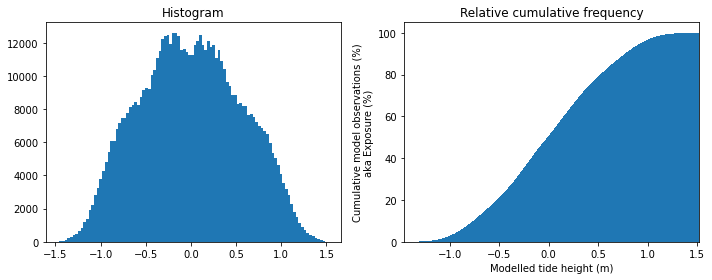

In [26]:
## Visualise the distribution of observations in the tidal model dataset and the relative CF distribution

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(modelledtides, bins=100)
ax1.set_title('Histogram')
ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
ax2.set_title('Relative cumulative frequency')
ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
ax2.set_xlabel('Modelled tide height (m)')
ax2.set_xlim([x.min(), x.max()])
fig.tight_layout()

In [27]:
## Save the *relative* cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights


CFdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
CF_df = pd.DataFrame(data=CFdict)

## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
shifted = CF_df.tideheight_max.shift(periods=1)
updatedvalue = CF_df.tideheight_max[0] - binsize
shifted.update(pd.Series([updatedvalue], index=[0]))

CF_df['tideheight_min']=shifted

CF_df['Elevation_midpoint'] = (CF_df.tideheight_max + CF_df.tideheight_min)/2
CF_df = CF_df.set_index('Elevation_midpoint')

## Create xarray object from cumulative frequency dataframe
CF_ds = xr.Dataset.from_dataframe(CF_df)


In [29]:
## Calculate the exposure dataset by indexing the NIDEM elevations against the 
## relative cumulative frequencies for those same elevations into a new dataset.
## Also, replace nan values in NIDEM with -9999 values to enable later masking of
## non-intertidal areas. This is a workaround for the .sel function failing to handle
## nans in the original NIDEM dataset.

Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem.fillna(-9999), method='nearest')

In [30]:
## Create a masked exposure dataset by removing tiny exposure values associated with
## NIDEM nans (-9999). This is a workaround for the above .sel function failing to handle
## nans in the original NIDEM dataset.

Exp_cf = Exposure.cumfreq.where(Exposure.cumfreq > 0.01) 

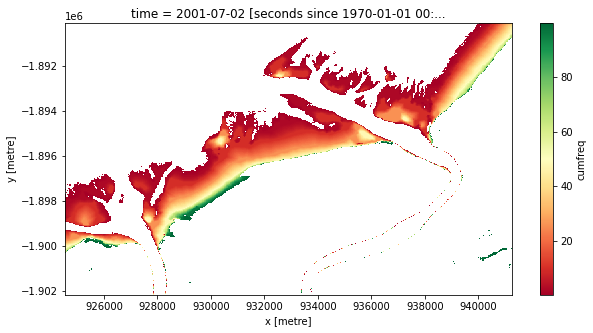

In [31]:
## Plot the results

Exp_cf.plot(cmap='RdYlGn', figsize=(10,5))

In [32]:
# Save a single time-slice as a cloud-optimised geotiff

rgb_da = Exp_cf.isel(time=0)#.to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=rgb_da,
          fname='binsize_'+str(binsize)+'_exp_CFmethod.tif',
          overwrite=True)


PosixPath('binsize_0.01_exp_CFmethod.tif')